# HW1 - baseline


В домашнем задании мы будем строить модель, которая предсказывает стимул/ отсутствие стимула на  ЭЭГ

In [9]:
# For Colab only
!pip install mne
!wget https://raw.githubusercontent.com/adasegroup/NEUROML2020/seminar1/seminar1/train.csv
!wget https://raw.githubusercontent.com/adasegroup/NEUROML2020/seminar1/seminar1/test.csv

/bin/bash: wget: command not found
/bin/bash: wget: command not found


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mne.time_frequency import psd_array_multitaper

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

%matplotlib inline

In [11]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [12]:
df_train.head()

,time,condition,epoch,C3,Cz,C4,Fp1,Fp2,F7,F3,...,F8,T7,T8,P7,P3,Pz,P4,P8,O1,O2
0,0,1,0,-5.885714,-2.533107,9.866895,7.962973,5.694433,23.638605,27.899784,...,23.588723,12.178548,0.685809,-4.887397,-10.646985,-14.735646,-8.729323,-0.562578,-17.055458,-3.616732
1,1,1,0,-7.999715,-16.916729,-11.924855,17.955477,8.526994,56.635981,28.508435,...,1.045533,14.656061,-4.119778,-4.632381,-17.980657,-23.456960,-12.960684,-9.639784,-20.233549,-1.229811
2,2,1,0,-6.727283,-15.979567,-11.114195,17.183478,4.497028,43.914130,10.079754,...,-14.741630,14.793562,-6.624813,-3.402757,-10.269473,-18.736144,-3.579046,-0.045658,-14.089755,2.453398
3,3,1,0,6.819390,-0.204905,10.090124,20.265222,7.843006,36.250611,13.291199,...,-7.135541,21.723418,-2.276825,2.066859,4.325365,-2.803322,8.835114,13.878945,-5.772410,7.657873
4,4,1,0,13.129486,-5.817193,5.040633,19.462210,9.634234,42.311729,20.641012,...,0.015602,19.703190,3.739076,2.714350,3.251047,-3.631448,3.212956,4.635574,-5.045448,5.086024


In [13]:
ch_names = df_train.columns[3:]

In [14]:
epochs = df_train['epoch'].unique()

In [15]:
epochs

array([  0,   2,   6,   8,  11,  13,  15,  16,  17,  18,  19,  20,  21,
        22,  23,  24,  25,  26,  29,  30,  31,  32,  33,  34,  36,  37,
        38,  39,  42,  43,  44,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  58,  60,  61,  62,  64,  65,  66,  67,  68,  69,
        74,  77,  79,  80,  81,  86,  87,  88,  89,  90,  91,  93,  95,
        96,  97,  99, 101, 102, 105, 107, 109, 110, 111, 113, 115, 117,
       118, 126, 127, 128, 129, 131, 134, 135, 136, 137, 138, 139, 141,
       142, 143, 144, 145, 147, 151, 152, 154, 155, 156, 157, 158, 159,
       160, 162, 164, 166, 167, 169, 171, 172, 173, 174, 175, 176, 177,
       181, 182, 184, 185, 187, 192, 193, 194, 196, 197, 200, 201, 202,
       204, 205, 210, 212, 216, 217, 221, 222, 223, 225, 226, 227, 228,
       230, 231, 233, 234, 235, 237, 239, 240, 241, 244, 245, 246, 248,
       250, 253, 254, 255, 261, 262, 263, 265, 268, 269, 270, 276, 277,
       279, 281, 283, 285, 287, 290, 292, 293, 294, 297, 298])

In [16]:
def get_target(df):
    return df.drop_duplicates('epoch')[['epoch', 'condition']].reset_index(drop=True)

## Idea for feature engineering

In [17]:
df_train[df_train['condition'] == 1]

,time,condition,epoch,C3,Cz,C4,Fp1,Fp2,F7,F3,...,F8,T7,T8,P7,P3,Pz,P4,P8,O1,O2
0,0,1,0,-5.885714,-2.533107,9.866895,7.962973,5.694433,23.638605,27.899784,...,23.588723,12.178548,0.685809,-4.887397,-10.646985,-14.735646,-8.729323,-0.562578,-17.055458,-3.616732
1,1,1,0,-7.999715,-16.916729,-11.924855,17.955477,8.526994,56.635981,28.508435,...,1.045533,14.656061,-4.119778,-4.632381,-17.980657,-23.456960,-12.960684,-9.639784,-20.233549,-1.229811
2,2,1,0,-6.727283,-15.979567,-11.114195,17.183478,4.497028,43.914130,10.079754,...,-14.741630,14.793562,-6.624813,-3.402757,-10.269473,-18.736144,-3.579046,-0.045658,-14.089755,2.453398
3,3,1,0,6.819390,-0.204905,10.090124,20.265222,7.843006,36.250611,13.291199,...,-7.135541,21.723418,-2.276825,2.066859,4.325365,-2.803322,8.835114,13.878945,-5.772410,7.657873
4,4,1,0,13.129486,-5.817193,5.040633,19.462210,9.634234,42.311729,20.641012,...,0.015602,19.703190,3.739076,2.714350,3.251047,-3.631448,3.212956,4.635574,-5.045448,5.086024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14575,76,1,298,23.570607,53.678503,40.020477,27.204096,26.102917,31.317942,37.206302,...,20.623106,30.746126,30.447045,24.371562,63.318084,45.096615,55.730871,-0.938503,22.668853,2.509574
14576,77,1,298,13.056247,44.617147,45.410663,10.309463,17.300958,11.984368,20.213478,...,12.086459,6.021088,11.759970,18.944535,48.614060,35.531916,48.503198,3.363448,30.176355,-2.327078
14577,78,1,298,8.096050,33.230096,37.263600,-0.926629,11.493239,5.080497,3.834894,...,4.615262,-5.846025,-1.331130,12.233314,43.337987,26.913521,37.720360,9.107918,29.064302,-3.277053
14578,79,1,298,0.264205,18.232656,14.506337,5.226056,16.266549,10.892078,22.920542,...,7.045203,13.300687,2.710775,6.088290,45.822626,15.439944,24.064720,5.471584,4.674299,-13.038201


<AxesSubplot:xlabel='time'>

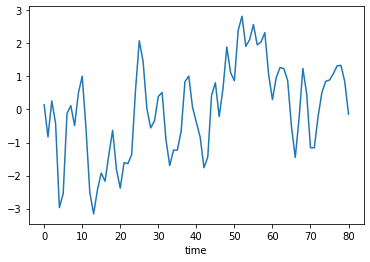

In [18]:
df_train[df_train['condition'] == 1].groupby('time')['F4'].mean().plot()

<AxesSubplot:xlabel='time'>

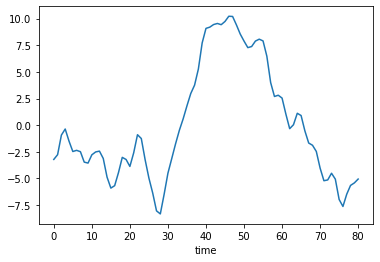

In [19]:
df_train[df_train['condition'] != 1].groupby('time')['F4'].mean().plot()

In [20]:
def calc_features(df):
    feats = []
    for epoch_idx, epoch_df in df.groupby('epoch'):

        epoch_df = epoch_df[ch_names]

        psds, freqs = psd_array_multitaper(epoch_df.T.values, 160, verbose=False)

        total_power = psds.sum(axis=1)

        idx_from = np.where(freqs > 13)[0][0]
        idx_to = np.where(freqs > 25)[0][0]
        b_pwr = psds[:,idx_from:idx_to].sum(axis=1) / total_power

        d = {}
        d['epoch'] = epoch_idx

        for ch in ch_names:
            s = epoch_df.iloc[40:][ch]
            val = (s > 5).sum()
            d[ch.lower() + '_p300'] = val

        feats.append(d)

    feats_df = pd.DataFrame(feats)
    
    return feats_df

## Common ML workflow

In [21]:
X = get_target(df_train)
X = X.merge(calc_features(df_train), on='epoch')
y = X['condition'].apply(lambda x: 0 if x == 1 else 1)
del X['epoch']
del X['condition']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [23]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [24]:
model = LogisticRegression(C=1)

In [25]:
model.fit(X_train_sc, y_train)

LogisticRegression(C=1)

In [26]:
y_pred_train = model.predict_proba(X_train_sc)[:, 1]
roc_auc_score(y_train, y_pred_train)

0.7982700892857142

In [27]:
y_pred = model.predict_proba(X_test_sc)[:, 1]

In [28]:
roc_auc_score(y_test, y_pred)

0.7171945701357466

## Visualize t-SNE

In [29]:
X_embedded = TSNE(n_components=2).fit_transform(X)

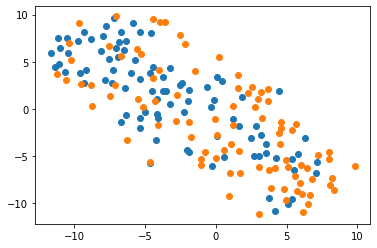

In [30]:
plt.scatter(X_embedded[np.where(y == 0), 0], X_embedded[np.where(y == 0), 1])
plt.scatter(X_embedded[np.where(y == 1), 0], X_embedded[np.where(y == 1), 1])

## Build submission

In [31]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

In [32]:
model.fit(X_sc, y)

LogisticRegression(C=1)

In [33]:
X_test = calc_features(df_test)
submission = X_test[['epoch']].copy()
del X_test['epoch']
X_test_sc = scaler.transform(X_test)

In [34]:
y_pred = model.predict_proba(X_test_sc)[:, 1]

In [35]:
submission['Predicted'] = y_pred

In [36]:
submission['Id'] = submission['epoch']
del submission['epoch']

In [37]:
submission.to_csv('baseline_submission.csv', index=False)